In [7]:
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
from stockstats import StockDataFrame 
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

import dataPreparation
files=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       

prices=list()
sentiment=list()
for file in files:
    
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    sentimentVector=[]
    meanvector=[]
    sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalSentiment/'+file+'.csv')
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDataset/indexes'+file+'.csv')
    #alignment of data
    maxdata=max(sentimentVector['initTime'])
    mindata=min(sentimentVector['initTime'])
    price=price[price['Unnamed: 0']>=mindata]
    price=price[price['Unnamed: 0']<=maxdata]
    sentimentVector=sentimentVector.drop(['Unnamed: 0', 'initTime' ], axis=1)
    meanvector=np.concatenate((sentimentVector,pd.rolling_mean(sentimentVector,5)),axis=1)
    meanvector=np.concatenate((meanvector,pd.rolling_mean(sentimentVector,10)),axis=1)
    meanvector=np.concatenate((meanvector,pd.rolling_mean(sentimentVector,15)),axis=1)
    meanvector=np.concatenate((meanvector,pd.rolling_mean(sentimentVector,20)),axis=1)
    

    price=price.drop(['Unnamed: 0'],axis=1)
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    sentiment.append(meanvector)
    
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=15,center=False).mean()
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()


In [10]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
def expercentage(y,prediction,percentage,t):
    tot=0
    falsetotpos=0
    falsetotneg=0
    for i in range(0,len(percentage)-1):
        if(prediction[i]==1):
            tot=tot+percentage[i]
        if(prediction[i]==0):
            tot=tot-percentage[i]
            
        falsetotpos=falsetotpos+percentage[i]
        falsetotneg=falsetotneg-percentage[i]
    
    return tot,falsetotneg, falsetotpos

Working on... AAPL
(2861, 25)
0.3593813663804626
Window: 0
[[173 110]
 [174 109]]
Percentages:
0.04267369801926313
3.114879117690502
-3.114879117690502
F1,score 0.4342629482071713
Accuracy: 0.49823321554770317
19.306977288832496
Window: 4
[[147 130]
 [159 129]]
Percentages:
15.877636535360805
12.467611863475335
-12.467611863475335
F1,score 0.47166361974405857
Accuracy: 0.48849557522123893
0.3593813663804626
Window: 5
[[195  87]
 [181 102]]
Percentages:
32.680631666771404
14.543820154875917
-14.543820154875917
F1,score 0.43220338983050843
Accuracy: 0.5256637168141592
1000.0
Window: 25
[[166 124]
 [173  98]]
Percentages:
-44.12459883494637
86.97819304983939
-86.97819304983939
F1,score 0.39756592292089254
Accuracy: 0.47058823529411764
1000.0
Window: 26
[[162 124]
 [170 105]]
Percentages:
-51.812969378931385
90.44439543423604
-90.44439543423604
F1,score 0.41666666666666663
Accuracy: 0.47593582887700536
10000.0
Window: 125
[[167 132]
 [136 106]]
Percentages:
91.61251137351736
227.1767857296

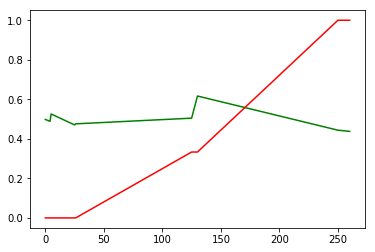

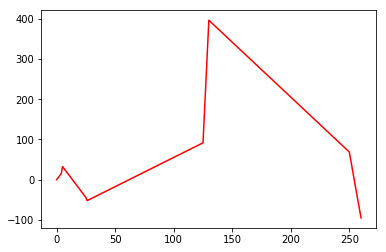

Working on... AMZN
(2718, 25)
0.005994842503189409
Window: 0
[[ 70 197]
 [ 72 200]]
Percentages:
-2.4970122159252233
-4.994913056703006
4.994913056703006
F1,score 0.5979073243647235
Accuracy: 0.5009276437847866
2.782559402207126
Window: 4
[[108 132]
 [117 181]]
Percentages:
34.950916690823796
-46.341624512069224
46.341624512069224
F1,score 0.5924713584288052
Accuracy: 0.5371747211895911
0.000774263682681127
Window: 5
[[ 34 205]
 [ 35 264]]
Percentages:
46.49719676450417
-55.99419574232674
55.99419574232674
F1,score 0.6875000000000001
Accuracy: 0.5539033457249071
31.622776601683793
Window: 25
[[ 95  95]
 [154 190]]
Percentages:
172.03121959982445
-207.71395516256067
207.71395516256067
F1,score 0.604133545310016
Accuracy: 0.5337078651685393
138.94954943731375
Window: 26
[[119  75]
 [163 177]]
Percentages:
246.49534136607474
-214.05743434948218
214.05743434948218
F1,score 0.5979729729729729
Accuracy: 0.5543071161048689
21.54434690031882
Window: 125
[[109  79]
 [ 86 240]]
Percentages:
755.

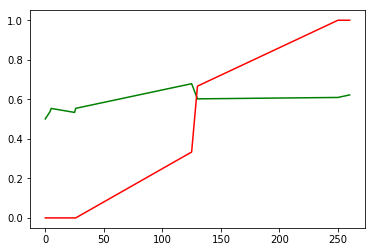

ValueError: x and y must have same first dimension, but have shapes (9,) and (18,)

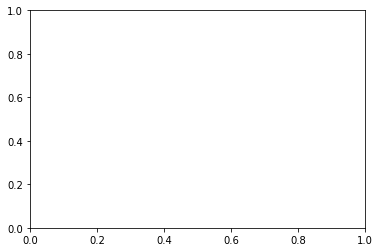

In [11]:
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]

for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    
    senttemp=sentiment[o]
    print(senttemp.shape)
    xtemp=price
    o+=1
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    senttemp=np.nan_to_num(np.asarray(senttemp, dtype=float))
    xtemp=normalize(xtemp,axis=0,norm='max')
    #print(xtemp)
    accintime=[]
    trendwindowtime=[0,4,5,25,26,125,130,250,260]
    f1total=[]
    acctotal=[]
    auctotal=[]
    f1scoretotal=[]
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        
        percentage=[]
        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            percentage.append((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
            if(s==-1):
                y.append(0)
            else:
                y.append(1)
            x.append(senttemp[i])
        y=np.array(y)
        percentage=np.array(percentage)
        x=np.array(x)
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        percentageTest=[]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        percentageTest=percentage[testindex]
    

        cspace=np.concatenate(((np.logspace(0,3,15)),np.logspace(-4,4,10)))
        gspace=[1]
        bestsvm=None
        maxacc=0
        cvacc=0
        maxg=0
        maxc=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for c in cspace:
            #print()
            for g in gspace:
                
                cvacclist=[]
                #faccio cross validation
                #start with 40% as train and 10% for validation and then i move in percentege
                # 0-40 40-50
                # 0-50 50-60
                # 0-60 60-70 
                #etc test set is completely external i do in some way error extimation changin the ticker
                trainpoint=math.floor(len(x_tv)*0.40)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                
                for i in range(0,6):
                    #print('-----')
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    #print(trainpoint)
                    #print(endval)
                    #print(len(x_tv))
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    p=sum(y_train)/(len(y_train)-sum(y_train))
                    rbf_svm=svm.SVC(C=c)
                    x_train,y_train=smote(x_train,y_train)
                    rbf_svm.fit(x_train,y_train)
                    #prediction=rbf_svm.predict(x_val)
                    if(sum(y_val)+6<len(x_val) and sum(y_val)>6):
                        x_val,y_val=smote(x_val,y_val)
                    else:
                        totu=totu+1
                    cvacclist.append(rbf_svm.score(x_val,y_val))
                cvacc=sum(cvacclist)/len(cvacclist)
                if(cvacc>maxacc):
                    #print(cvacc)
                    maxacc=cvacc
                    
                    maxc=c
                    bestsvm=rbf_svm

        #print('ACCURACY on val:',maxacc)
        p=sum(y_tv)/(len(y_tv)-sum(y_tv))
        print(maxc)
        rbf_svm=svm.SVC(C=maxc)
        x_tv,y_tv=smote(x_tv,y_tv)
        rbf_svm.fit(x_tv,y_tv)
        prediction=rbf_svm.predict(x_test)
        totperc,pos, neg= expercentage(y_test,prediction,percentageTest,t)
        confmatrix=confusion_matrix(y_test, prediction)
        print('Window:',t)
        print(confmatrix)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        CM = f1_score(y_test, prediction)
        valueacc=rbf_svm.score(x_test,y_test)
        #print('Accuracy on TEST set:',testacc
        print('Percentages:')
        print(totperc)
        print(pos)
        print(neg)
        print('F1,score',CM)
        print('Accuracy:',valueacc)
        percfinal.append(totperc)
        f1scoretotal.append(CM)
        f1total.append(totu)
        acctotal.append(valueacc)
        auctotal.append(auc)
    print(f1total)
    print(acctotal)
    print('accuracy')
    print('accuracy')
    f1total=normalize(np.asarray(f1total).reshape(-1,1),axis=0,norm='max')
    plt.plot(trendwindowtime,acctotal,'g')
    plt.plot(trendwindowtime,f1total,'r')
    plt.show()
    plt.plot(trendwindowtime,percfinal,'r')
    plt.show()
    f1scoreresults.append(f1scoretotal)
    accstocksresults.append(acctotal)
    f1stocksresults.append(f1total)
    aucresults.append(auctotal)
for p in accstocksresults:
    plt.plot(p)
plt.show()

In [47]:
tempacc=aucresults

In [48]:
print(len(prices[0]))

2834


[0.50074031 0.49808615 0.50250904 0.49133483 0.48435518 0.54217406
 0.54446475 0.51094649 0.50932833]


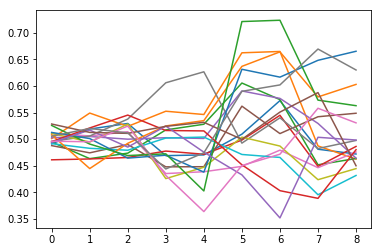

In [49]:
import operator
t=[0,0,0,0,0,0,0,0,0]
for i in range(0,len(tempacc)):
    #for k in range(0,len(tempacc[i])):
        #print(tempacc[i][k])
     #   if(tempacc[i][k]<0.5):
      #     tempacc[i][k]=1-tempacc[i][k]
    t=np.add(t,tempacc[i])
    plt.plot(tempacc[i])
print(t/len(tempacc))
plt.show()

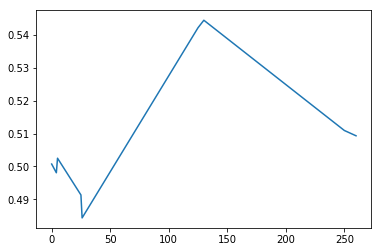

In [50]:
plt.plot(trendwindowtime,t/len(tempacc))
plt.show()

COST
[0.48624862486248627, 0.4977973568281938, 0.526431718061674, 0.4314159292035398, 0.3639380530973451, 0.40384615384615385, 0.42242355605889015, 0.5040745052386496, 0.5612602100350058]
0.4663817896924376


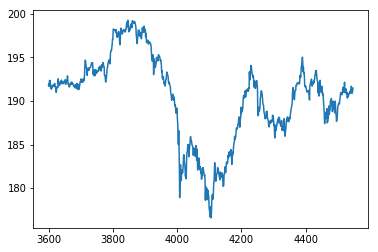

AAPL
[0.4911660777385159, 0.5168141592920354, 0.5292035398230088, 0.47237076648841353, 0.47237076648841353, 0.5138632162661737, 0.5833333333333334, 0.45155038759689925, 0.44357976653696496]
0.49713911261819543


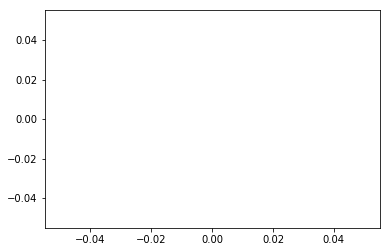

AVGO
[0.49834983498349833, 0.5198237885462555, 0.5440528634361234, 0.5165929203539823, 0.5154867256637168, 0.4671945701357466, 0.43035107587768967, 0.44935972060535506, 0.5367561260210035]
0.4975519584025968


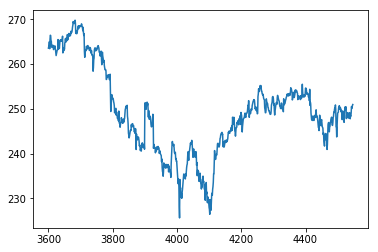

NVDA
[0.5104510451045104, 0.4977973568281938, 0.5297356828193832, 0.43805309734513276, 0.4646017699115044, 0.5328054298642534, 0.5175537938844847, 0.4807916181606519, 0.5110851808634772]
0.49809721942017693


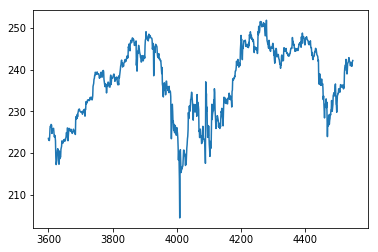

CSCO
[0.5104510451045104, 0.5077092511013216, 0.51431718061674, 0.4413716814159292, 0.44579646017699115, 0.4819004524886878, 0.5334088335220838, 0.5308498253783469, 0.5507584597432905]
0.5018403543942113


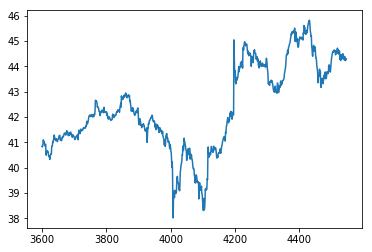

NFLX
[0.5016501650165016, 0.5110132158590308, 0.4966960352422907, 0.46017699115044247, 0.4469026548672566, 0.5260180995475113, 0.5175537938844847, 0.5331781140861467, 0.5355892648774796]
0.5031975927256827


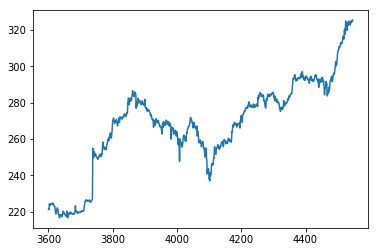

PYPL
[0.4961496149614962, 0.5352422907488987, 0.5319383259911894, 0.5265486725663717, 0.536504424778761, 0.4830316742081448, 0.35900339750849375, 0.559953434225844, 0.5390898483080513]
0.5074957425885834


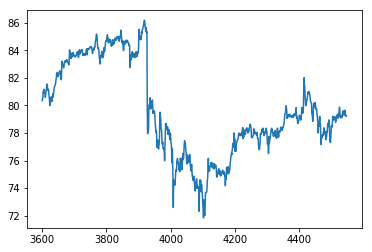

GILD
[0.5269526952695269, 0.5044052863436124, 0.4955947136563877, 0.4889380530973451, 0.4922566371681416, 0.49321266968325794, 0.549263873159683, 0.5820721769499418, 0.44807467911318555]
0.5089745316045646


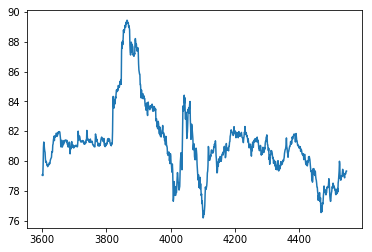

GOOGL
[0.4949874686716792, 0.4742785445420326, 0.4893350062735257, 0.5296343001261034, 0.5372005044136192, 0.610608020698577, 0.5777202072538861, 0.44919786096256686, 0.467828418230563]
0.5145322590191725


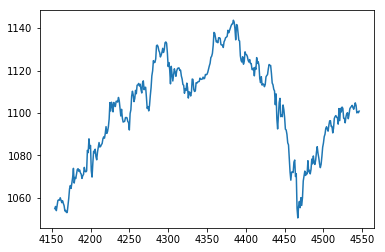

FB
[0.5143487858719646, 0.5049723756906077, 0.5005524861878453, 0.4972253052164262, 0.49500554938956715, 0.565266742338252, 0.5556818181818182, 0.5373831775700935, 0.46955503512880564]
0.5155545861750422


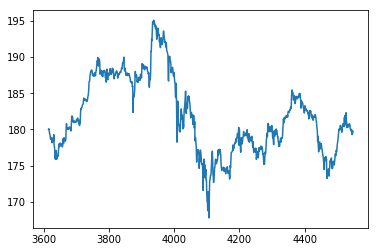

CMCSA
[0.4884488448844885, 0.5066079295154186, 0.5374449339207048, 0.6128318584070797, 0.629424778761062, 0.4852941176470588, 0.5334088335220838, 0.4179278230500582, 0.43990665110851807]
0.5168106412018303


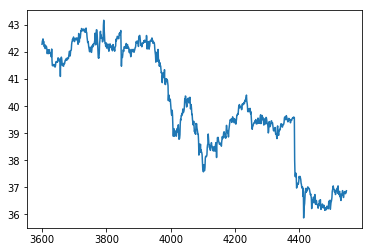

INTC
[0.48954895489548955, 0.47687224669603523, 0.4856828193832599, 0.4579646017699115, 0.47013274336283184, 0.6425339366515838, 0.6194790486976217, 0.5471478463329453, 0.5764294049008168]
0.529532400298944


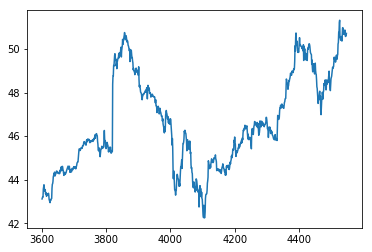

AMGN
[0.5082508250825083, 0.45044052863436124, 0.4933920704845815, 0.5254424778761062, 0.5337763012181617, 0.6018099547511312, 0.622876557191393, 0.5343422584400466, 0.558926487747958]
0.5365841623806942


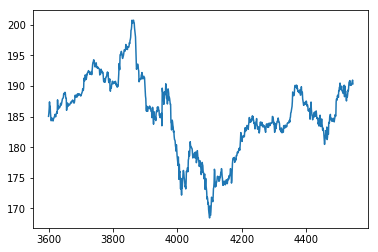

MSFT
[0.46314631463146316, 0.5033039647577092, 0.5033039647577092, 0.5630530973451328, 0.5630530973451328, 0.5429864253393665, 0.5821064552661381, 0.5448195576251456, 0.5799299883313885]
0.5384114294887984


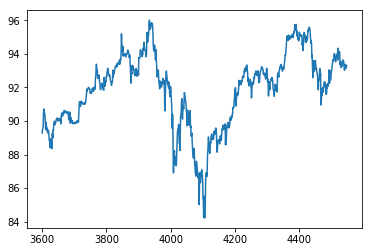

ADBE
[0.504950495049505, 0.5022026431718062, 0.46365638766519823, 0.45464601769911506, 0.46017699115044247, 0.6447963800904978, 0.6036240090600227, 0.6321303841676368, 0.6394399066511085]
0.5450692460783703


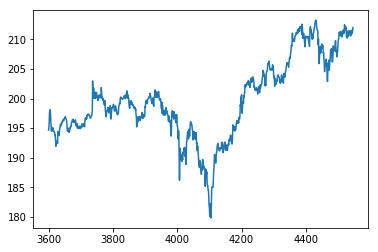

TXN
[0.5249169435215947, 0.49058693244739754, 0.46452328159645234, 0.47216035634743875, 0.410913140311804, 0.715261958997722, 0.7160775370581528, 0.5756154747948418, 0.5628672150411281]
0.5481025377907257


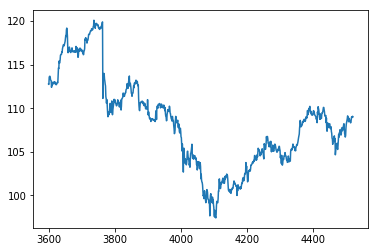

QCOM
[0.5093509350935094, 0.5198237885462555, 0.5110132158590308, 0.42035398230088494, 0.4446902654867257, 0.6199095022624435, 0.6285390713476784, 0.6880093131548312, 0.6371061843640606]
0.55319958426838


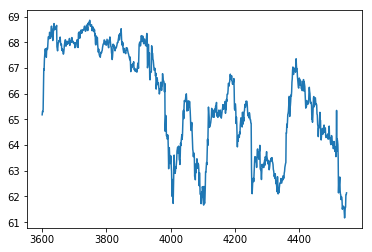

AMZN
[0.5027829313543599, 0.5557620817843866, 0.5390334572490706, 0.5449438202247191, 0.5393258426966292, 0.6789883268482491, 0.682261208576998, 0.6114519427402862, 0.6119096509240246]
0.5851621402665248


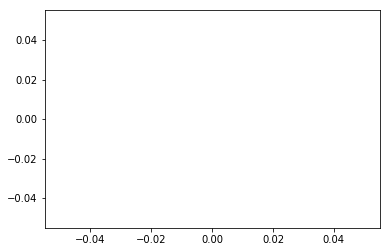

In [7]:
meanvalue=[]
for i in range(0,len(tempacc)):
    meanvalue.append(np.mean(tempacc[i]))
top10=np.argsort(meanvalue)[:20]
for i in range(0,len(top10)):
    print(files[top10[i]])
    print(tempacc[top10[i]])
    print(meanvalue[top10[i]])
    plt.plot(prices[top10[i]].iloc[3600:]['close'])
    plt.show()

In [9]:
#, 'AMZN', 'ATVI', 'AVGO', 'BIDU', 
          'BIIB', 'BMRN', 'CA', 'CELG', 'CERN', 'CHTR', 'CMCSA',
          'COST', 'CSCO', 'CSX', 'CTAS', 'CTRP', 'CTSH', 'CTXS',
          'DISCA', 'DISH', 'DLTR', 'EA', 'EBAY', 'ESRX', 'EXPE',
          'FAST', 'FB', 'FISV', 'FOXA', 'GILD', 'GOOGL', 'HAS',
          'HOLX', 'HSIC', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU',
          'ISRG', 'JBHT', 'JD', 'KHC', 'KLAC', 'LBTYA', 'LRCX', 'MAR',
          'MAT', 'MCHP', 'MDLZ', 'MELI', 'MNST', 'MSFT', 'MU', 'MXIM',
          'MYL', 'NFLX', 'NTES', 'NVDA', 'ORLY', 'PAYX', 'PCAR', 'PCLN',
          'PYPL', 'QCOM', 'REGN', 'ROST', 'SBUX', 'SHPG', 'SIRI', 'STX',
          'SWKS', 'SYMC', 'TMUS', 'TSCO', 'TSLA', 'TXN', 'ULTA', 'VIAB',
          'VOD', 'VRSK', 'VRTX', 'WBA', 'WYNN', 'XLNX', 'XRAY']

IndentationError: unexpected indent (<ipython-input-9-38986ef67f6e>, line 2)